# Sentiment agent model

Creating a sentiment agent model that may predict the mean sentiment of microblogging environment by predicting the influence of existing posts on a posting agent. 

Written by Luc Bijl.

## The subset $S$ of the set of all posts $P$

Importing the test posts set.

In [1]:
import pandas as pd

# Importing the csv dataset
import_posts = '../datasets/test-posts/test-posts-scored.csv'
df_posts = pd.read_csv(import_posts)

df_posts.head(6)

,Date,Text,S,V,A,D
0,2024-01-02 14:40:00,I hate my fucking life.,-0.482720,-0.430294,0.612063,0.354783
1,2024-01-01 12:12:31,"Greetings fellow humanoid, how are you doing?",0.246881,0.450770,0.407472,0.218679
2,2023-12-31 19:39:00,This microblogging platform is dismal in every...,-0.447901,-0.445385,0.118963,0.152460
3,2023-12-28 06:12:00,Politics is a joke.,-0.411837,0.663786,0.738927,0.440982
4,2023-12-26 13:25:00,I am sorry for my bad behaviour. Can I make it...,0.118153,-0.096516,0.142977,-0.136444
5,2023-12-12 16:16:16,"The universe is irrational and meaningless, I ...",-0.465270,-0.028720,0.032311,0.033977


Creating the set $P$ of all posts, by taking a time point $t_0$ for which the model should start.

In [2]:
# Stating the time point
time_start = pd.to_datetime('2024-01-03 00:00:00')

# Defining the set P of all posts
P = []

# Determining the posts from before the time point and appending the necessary information to P
for index, row in df_posts.iterrows():
    t_row = pd.to_datetime(row['Date'])
    if t_row < time_start:
        P.append([time_start - t_row] + list(row[['S', 'V', 'A', 'D']]))

df_P = pd.DataFrame(P, columns=['age', 's', 'v', 'a', 'd'])

df_P.head(6)

,age,s,v,a,d
0,0 days 09:20:00,-0.482720,-0.430294,0.612063,0.354783
1,1 days 11:47:29,0.246881,0.450770,0.407472,0.218679
2,2 days 04:21:00,-0.447901,-0.445385,0.118963,0.152460
3,5 days 17:48:00,-0.411837,0.663786,0.738927,0.440982
4,7 days 10:35:00,0.118153,-0.096516,0.142977,-0.136444
5,21 days 07:43:44,-0.465270,-0.028720,0.032311,0.033977


Determining the probability to be included in the subset $S$.

In [3]:
import numpy as np
from functools import reduce
import operator

# Defining the parameters for the subset probability.
params = {}

params['sp'] = {'age': 0.1, 
                's': [[0.4, 1.5, 1], [0.6, -1.5, -1]],
                'v': [[0.4, 1.5, 1], [0.6, -1.5, -1]],
                'a': [[1, 2, 0]],
                'd': [[1, 0.5, 0]]}

# Defining the age function.
def age_function(var, params):
    return np.exp(-(params * var.days))

# Defining the sum of sigmoid functions.
def sigmoid_sum(var, params):
    output = 0
    for a, b, c in params:
        output += a / (1 + np.exp(-b * (var - c)))
    return np.clip(output, 0, 1)

# Defining the main probability function.
def g(p, params):
    return age_function(p['age'], params['age']) * reduce(operator.mul, [sigmoid_sum(p[i], params[i]) for i in ['s', 'v', 'a', 'd']])

# Determining the normalization sum of g for P.
normal_sum = sum(g(row.to_dict(), params['sp']) for _, row in df_P[['age', 's', 'v', 'a', 'd']].iterrows())

# Determining the probability for each entry in P.
if normal_sum > 0:
        rho = [g(row.to_dict(), params['sp']) for _, row in df_P[['age', 's', 'v', 'a', 'd']].iterrows()] / normal_sum
else: rho = None

df_P['rho'] = rho

df_P.head(6)

,age,s,v,a,d,rho
0,0 days 09:20:00,-0.482720,-0.430294,0.612063,0.354783,0.344908
1,1 days 11:47:29,0.246881,0.450770,0.407472,0.218679,0.175134
2,2 days 04:21:00,-0.447901,-0.445385,0.118963,0.152460,0.192508
3,5 days 17:48:00,-0.411837,0.663786,0.738927,0.440982,0.191255
4,7 days 10:35:00,0.118153,-0.096516,0.142977,-0.136444,0.074689
5,21 days 07:43:44,-0.465270,-0.028720,0.032311,0.033977,0.021506


Creating the subset $S$.

In [4]:
# Defining the cardinality m of the subset S.
m = 3

# Creating the subset.
df_S = df_P.loc[np.random.choice(df_P.index, size=m, replace=False, p=df_P['rho'])]

df_S.head()

,age,s,v,a,d,rho
0,0 days 09:20:00,-0.482720,-0.430294,0.612063,0.354783,0.344908
1,1 days 11:47:29,0.246881,0.450770,0.407472,0.218679,0.175134
2,2 days 04:21:00,-0.447901,-0.445385,0.118963,0.152460,0.192508


## The initial state of the agent

Creating the probability distribution function of the set $P$ and the initial state function.

In [5]:
from sklearn.neighbors import KernelDensity

# Defining the bandwidth of the kernel density function.
kernel_bandwidth = 0.1

# Defining the initial state function.
def create_initial_state(df_P, bandwidth):
    kde_models = {}

    # Fitting a kde for each column.
    for i in ['s', 'v', 'a', 'd']:
        kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
        kde.fit(df_P[i].values.reshape(-1,1))
        kde_models[i] = kde

    # Generating a new random entry for each column.
    new_entries = {}
    for i, kde_model in kde_models.items():
        new_entry = np.clip(kde_model.sample(), -1, 1)
        new_entries[i] = new_entry.item()
    
    return new_entries

# Creating an initial state with the defined function.
u = create_initial_state(df_P, kernel_bandwidth)

print(u)

{'s': 0.09274059783581809, 'v': 0.3584908513011889, 'a': 0.19062419146359458, 'd': 0.19121670647639227}


Creating a plot of the probability distributions of the set $P$. 

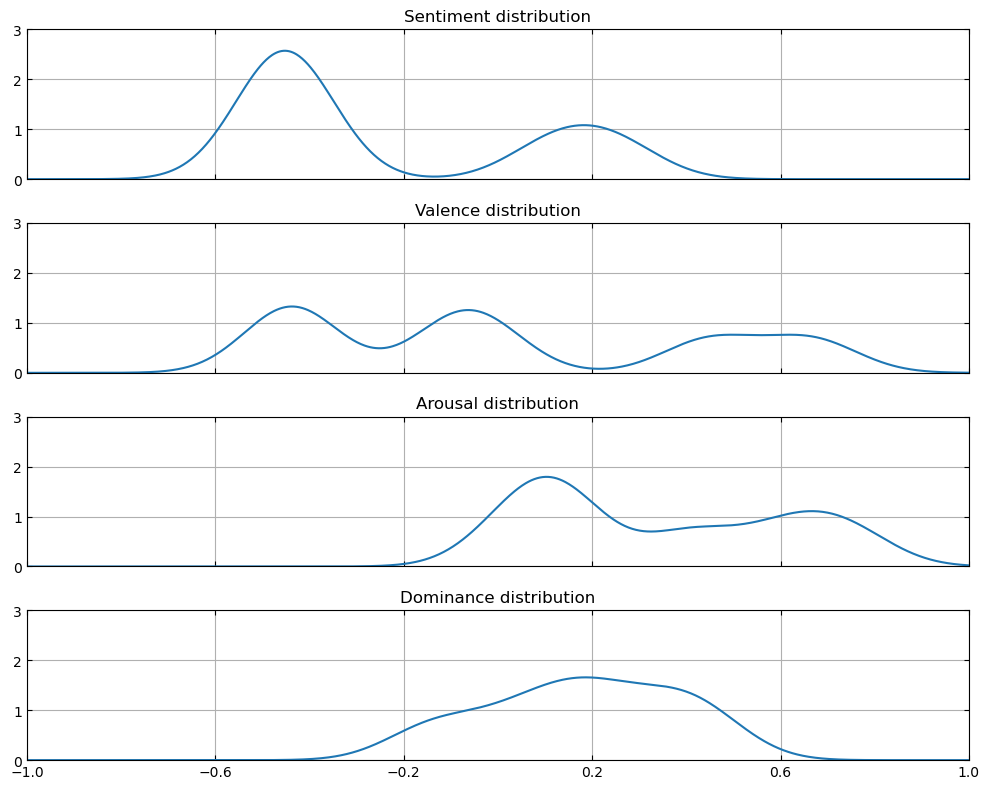

In [12]:
import matplotlib.pyplot as plt

# Choose the columns for KDE
columns_to_kde = ['s', 'v', 'a', 'd']

# Set up subplots for each column
fig, axes = plt.subplots(nrows=len(columns_to_kde), figsize=(10, 2 * len(columns_to_kde)), sharex=True)

# Fit a separate KDE for each column and plot the distribution
for i, col, n in zip([0,1,2,3],columns_to_kde, ['Sentiment', 'Valence', 'Arousal', 'Dominance']):
    col_data = df_P[col].values.reshape(-1, 1)
    
    # Fit KDE
    kde = KernelDensity(bandwidth=kernel_bandwidth, kernel='gaussian')
    kde.fit(col_data)
    
    # Generate x values for the plot
    x_values = np.linspace(-1, 1, 1000).reshape(-1, 1)
    
    # Evaluate the KDE at the x values
    log_dens = kde.score_samples(x_values)
    density = np.exp(log_dens)
    
    # Plot the distribution
    axes[i].plot(x_values, density, label=f'{col} Distribution')
    axes[i].set_title(f'{n} distribution')
    axes[i].set_xlim(-1, 1)
    axes[i].set_ylim(0,3)
    axes[i].grid(True)
    axes[i].tick_params(axis='both', direction='in',top=True, right=True)
    axes[i].set_xticks(np.linspace(-1, 1, 7))
    axes[i].set_xlabel(r'$u_i$')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## The influence function

Creating the probability influence function. 

In [11]:
# Defining the parameters for the contagion influence function.
params['cif'] = [[1, -1.5, 3]]

# Defining the contagion influence function.
def contagion_influence_function(u, p, params_cif):
    # Determining the influence/contagion factor.
    epsilon = sigmoid_sum(reduce(operator.add, [abs(u[i] - p[i]) for i in ['v', 'a', 'd']]), params_cif)
    
    # Returning the influenced state.
    return epsilon * np.array(list(u.values())) + (epsilon - 1) * np.array(list(p.values()))

v = (1/m) * sum(contagion_influence_function(u, row.to_dict(), params['cif']) for _, row in df_S[['s', 'v', 'a', 'd']].iterrows())

print(v)

[ 0.215285   -0.01144596 -0.41907984 -0.21291987]


## The post probability

Defining the post probability function.

In [76]:
# Defining the parameters for the post probability.
params['pp'] = {'s': [[0.8, 7, 0.05], [0.8, -7, -0.05]],
                'v': [[0.8, 7, 0.05], [0.8, -7, -0.05]],
                'a': [[1, 2, -1]],
                'd': [[0.8, 7, 0.05], [0.8, -7, -0.05]]}

# Defining the post probability function.
def h(v, params):
    return reduce(operator.mul, [sigmoid_sum(v[i], params[i]) for i in ['s', 'v', 'a', 'd']])

Defining the post boolean return function based on h.

In [85]:
# Restating the influenced state v.
v = {'s': 0.4, 'v': 0.6, 'a': -0.8, 'd': 0.1}

# Defining the post boolean return function based on h.
def post_boolean(v, params):
    probability = h(v, params['pp'])
    return np.random.choice([True, False], p=[probability, 1 - probability])

post_boolean(v, params['pp'])

False